In [60]:
# Face Detection Model
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import albumentations as alb
import tensorflow as tf
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## Collecting Data and Labelling 

In [61]:
images_path = 'data/images_path'
no_images = 30

## Setting up Camera

In [62]:
"""#Connecting to our camera
cap = cv2.VideoCapture(0)
for imgnum in range(no_images):
    print(f'Collecting image number {imgnum}') #Printing the image number
    ret, frame = cap.read() #Reading the frame
    imgname = os.path.join(images_path, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()"""

"#Connecting to our camera\ncap = cv2.VideoCapture(0)\nfor imgnum in range(no_images):\n    print(f'Collecting image number {imgnum}') #Printing the image number\n    ret, frame = cap.read() #Reading the frame\n    imgname = os.path.join(images_path, f'{str(uuid.uuid1())}.jpg')\n    cv2.imwrite(imgname, frame)\n    cv2.imshow('frame', frame)\n    time.sleep(0.5)\n    \n    if cv2.waitKey(1) & 0xFF == ord('q'):\n        break\ncap.release()\ncv2.destroyAllWindows()"

In [63]:
"!labelme" # Running the labelme command to annotate the images

'!labelme'

## Review Dataset and Build an Image Loading Function

In [64]:
#images = tf.data.Dataset.list_files('data/images/*.jpg')
#images.as_numpy_iterator().next()
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img
#images = images.map(load_image)
#images.as_numpy_iterator().next()
#type(images)



### View Images in Matplotlib

In [65]:
""""image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()"""

'"image_generator = images.batch(4).as_numpy_iterator()\nplot_images = image_generator.next()\nfig, ax = plt.subplots(ncols=4, figsize=(20,20))\nfor idx, image in enumerate(plot_images):\n    ax[idx].imshow(image)\nplt.show()'

## Partitioning Unaugmented Data 

We want 70% in the training set , 15% in both the test and validation set


In [66]:
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
"""
# Set the paths for your directories
source_dir = 'data/images'
train_dir = 'data/train/images'
val_dir = 'data/val/images'
test_dir = 'data/test/images'

# Create directories if they don't exist
Path(train_dir).mkdir(parents=True, exist_ok=True)
Path(val_dir).mkdir(parents=True, exist_ok=True)
Path(test_dir).mkdir(parents=True, exist_ok=True)

# Get all file names in the source directory
file_names = os.listdir(source_dir)

# Split the file names into training and temp sets (70% training, 30% temp)
train_files, temp_files = train_test_split(file_names, test_size=0.3, random_state=42)

# Further split the temp set into validation and test sets (50% validation, 50% test of the temp set)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Function to move files
def move_files(file_list, dest_dir):
    for file_name in file_list:
        shutil.move(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

# Move the files
move_files(train_files, train_dir)
move_files(val_files, val_dir)
move_files(test_files, test_dir)

print(f"Moved {len(train_files)} files to {train_dir}")
print(f"Moved {len(val_files)} files to {val_dir}")
print(f"Moved {len(test_files)} files to {test_dir}")"""


'\n# Set the paths for your directories\nsource_dir = \'data/images\'\ntrain_dir = \'data/train/images\'\nval_dir = \'data/val/images\'\ntest_dir = \'data/test/images\'\n\n# Create directories if they don\'t exist\nPath(train_dir).mkdir(parents=True, exist_ok=True)\nPath(val_dir).mkdir(parents=True, exist_ok=True)\nPath(test_dir).mkdir(parents=True, exist_ok=True)\n\n# Get all file names in the source directory\nfile_names = os.listdir(source_dir)\n\n# Split the file names into training and temp sets (70% training, 30% temp)\ntrain_files, temp_files = train_test_split(file_names, test_size=0.3, random_state=42)\n\n# Further split the temp set into validation and test sets (50% validation, 50% test of the temp set)\nval_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)\n\n# Function to move files\ndef move_files(file_list, dest_dir):\n    for file_name in file_list:\n        shutil.move(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name)

In [67]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

 ## Setup Albumentations Transform Pipeline


In [68]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### Test augmentation of photo

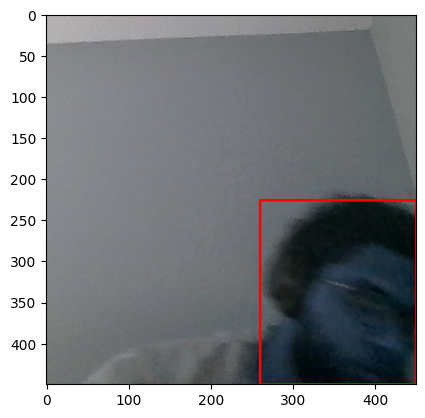

In [69]:
img = cv2.imread(os.path.join('data','train', 'images','1a585535-3658-11ef-8443-dc4628a0daab.jpg'))

with open(os.path.join('data', 'train', 'labels', '1a585535-3658-11ef-8443-dc4628a0daab.json'), 'r') as f:
    label = json.load(f)
    
    
coords = [point for pair in label['shapes'][0]['points'] for point in pair]


coords = list(np.divide(coords, [640,480,640,480]))
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

## Augmentation Pipeline 

In [70]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords = [point for pair in label['shapes'][0]['points'] for point in pair]

            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.16, 0.7833333333333333, -2.2204460492503132e-17, 0.2876846307385229, 'face'].


In [71]:
def preprocess_image(image):
    image = load_image(image)
    image = tf.image.resize(image, (120, 120))
    image = image / 255.0
    return image

def create_dataset(pattern):
    dataset = tf.data.Dataset.list_files(pattern, shuffle=False)
    dataset = dataset.map(preprocess_image)
    return dataset

train_images = create_dataset('aug_data\\train\\images\\*.jpg')
test_images = create_dataset('aug_data\\test\\images\\*.jpg')
val_images = create_dataset('aug_data\\val\\images\\*.jpg')

In [89]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        
    class_label = tf.constant([label['class']], dtype=tf.uint8)  # Ensure it is a list
    bbox_label = tf.constant(label['bbox'], dtype=tf.float32)
    return class_label, bbox_label

In [73]:
def create_label_dataset(pattern, load_func):
    dataset = tf.data.Dataset.list_files(pattern, shuffle=False)
    dataset = dataset.map(lambda x: tf.py_function(load_func, [x], [tf.uint8, tf.float16]))
    return dataset

# Define your load_labels function as needed
# def load_labels(filename):
#     # Your implementation to load labels from the JSON file
#     pass

# Create datasets for training, validation, and test sets
train_labels = create_label_dataset('aug_data\\train\\labels\\*.json', load_labels)
test_labels = create_label_dataset('aug_data\\test\\labels\\*.json', load_labels)
val_labels = create_label_dataset('aug_data\\val\\labels\\*.json', load_labels)

In [74]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels) # Check the number of images and labels


(3720, 3720, 840, 840, 780, 780)

We want to have a dataset here each sample is an image AND its corresponding label.

In [75]:
def prepare_dataset(images, labels, shuffle_buffer, batch_size, prefetch_buffer):
    dataset = tf.data.Dataset.zip((images, labels))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(prefetch_buffer)
    return dataset

# Define your datasets
train_images = create_dataset('aug_data\\train\\images\\*.jpg')
train_labels = create_label_dataset('aug_data\\train\\labels\\*.json', load_labels)

test_images = create_dataset('aug_data\\test\\images\\*.jpg')
test_labels = create_label_dataset('aug_data\\test\\labels\\*.json', load_labels)

val_images = create_dataset('aug_data\\val\\images\\*.jpg')
val_labels = create_label_dataset('aug_data\\val\\labels\\*.json', load_labels)

# Prepare the datasets
train = prepare_dataset(train_images, train_labels, shuffle_buffer=5000, batch_size=8, prefetch_buffer=4)
test = prepare_dataset(test_images, test_labels, shuffle_buffer=1300, batch_size=8, prefetch_buffer=4)
val = prepare_dataset(val_images, val_labels, shuffle_buffer=1000, batch_size=8, prefetch_buffer=4)
# Debugging: Print the shape of a batch
for batch in train.take(1):
    print("Batch image shape:", batch[0].shape)
    class_labels, bbox_labels = batch[1]
    print("Batch class label shape:", class_labels.shape)
    print("Batch bbox label shape:", bbox_labels.shape)

Batch image shape: (8, 120, 120, 3)
Batch class label shape: (8, 1)
Batch bbox label shape: (8, 4)


In [76]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0]], dtype=uint8),
 array([[0.     , 0.555  , 0.2329 , 1.     ],
        [0.     , 0.3857 , 0.3726 , 0.976  ],
        [0.     , 0.502  , 0.1938 , 1.     ],
        [0.401  , 0.11066, 0.8594 , 0.658  ],
        [0.4792 , 0.08215, 0.989  , 0.6187 ],
        [0.3672 , 0.386  , 0.8706 , 0.9565 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

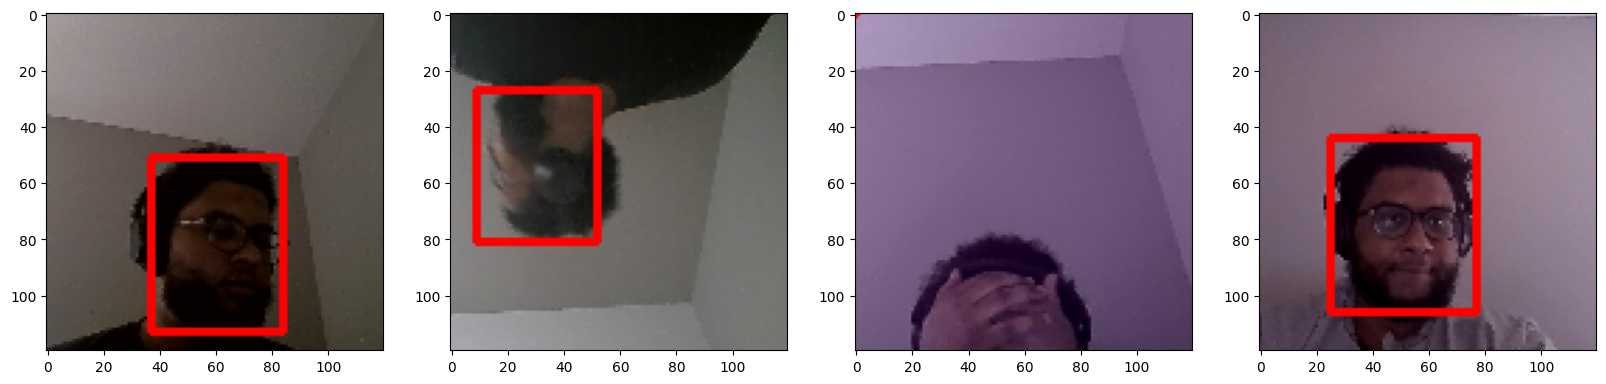

In [77]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
     # Make a writable copy of the image
    sample_image_writable = sample_image.copy()

    cv2.rectangle(sample_image_writable, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_image_writable)

plt.show()

## Building and Training Deep Learning Model

In [78]:
# Importing Libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [79]:
# Create instance of VGG16 model
vgg = VGG16(include_top=False) # Include top layer is set to False to remove the top layer because we will the classification layer and create our own regression layer

In [80]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Building the neural network

def build_model():
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [82]:
# Testing the model
facetracker = build_model()
facetracker.summary()
X, y = train.as_numpy_iterator().next()
X.shape
classes, coords = facetracker.predict(X)



Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │      2,049 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 4)         │      8,196 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [83]:
classes, coords

(array([[0.5081954 ],
        [0.39463705],
        [0.4333901 ],
        [0.42773896],
        [0.47427273],
        [0.40579876],
        [0.4008278 ],
        [0.35687983]], dtype=float32),
 array([[0.5852326 , 0.55175865, 0.67677397, 0.49960318],
        [0.61386573, 0.62222385, 0.6595764 , 0.55105495],
        [0.6310222 , 0.62402374, 0.6738379 , 0.550045  ],
        [0.60743725, 0.5866576 , 0.67622006, 0.53182524],
        [0.58523893, 0.5393847 , 0.6986642 , 0.54261047],
        [0.659759  , 0.64595973, 0.57495785, 0.53688073],
        [0.57607883, 0.6004045 , 0.69060516, 0.55127573],
        [0.60756445, 0.6141169 , 0.63766897, 0.5518792 ]], dtype=float32))

We need different loss function for the classification model and the regression model

In [84]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)


c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [85]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [86]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## Creating Training Pipeline


In [93]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs): 
        X, y = batch
        y_class, y_bbox = y
        
        # Explicitly set shapes for y_class and y_bbox
        y_class = tf.ensure_shape(y_class, [None, 1])
        y_bbox = tf.ensure_shape(y_bbox, [None, 4])
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(y_class, classes)
            batch_localizationloss = self.lloss(tf.cast(y_bbox, tf.float32), coords)
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs): 
        X, y = batch
        y_class, y_bbox = y
        
        # Explicitly set shapes for y_class and y_bbox
        y_class = tf.ensure_shape(y_class, [None, 1])
        y_bbox = tf.ensure_shape(y_bbox, [None, 4])
        
        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y_class, classes)
        batch_localizationloss = self.lloss(tf.cast(y_bbox, tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [94]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

# Train the model
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train.take(20), epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - class_loss: 0.2486 - regress_loss: 0.6576 - total_loss: 0.7818 - val_class_loss: 0.3490 - val_regress_loss: 0.6612 - val_total_loss: 0.8357
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - class_loss: 0.2411 - regress_loss: 0.6508 - total_loss: 0.7713 - val_class_loss: 0.1637 - val_regress_loss: 0.2014 - val_total_loss: 0.2833
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - class_loss: 0.1745 - regress_loss: 0.5603 - total_loss: 0.6475 - val_class_loss: 0.4792 - val_regress_loss: 0.6869 - val_total_loss: 0.9264
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - class_loss: 0.0594 - regress_loss: 0.2780 - total_loss: 0.3076 - val_class_loss: 0.0427 - val_regress_loss: 0.1266 - val_total_loss: 0.1479
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - class_loss: 0.1200 - regress_loss: 0.3925 - total_loss: 0.4525 - val_class_loss: 0.4738 - val_regress_loss: 0.3315 - val_total_loss: 0.5684
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 71

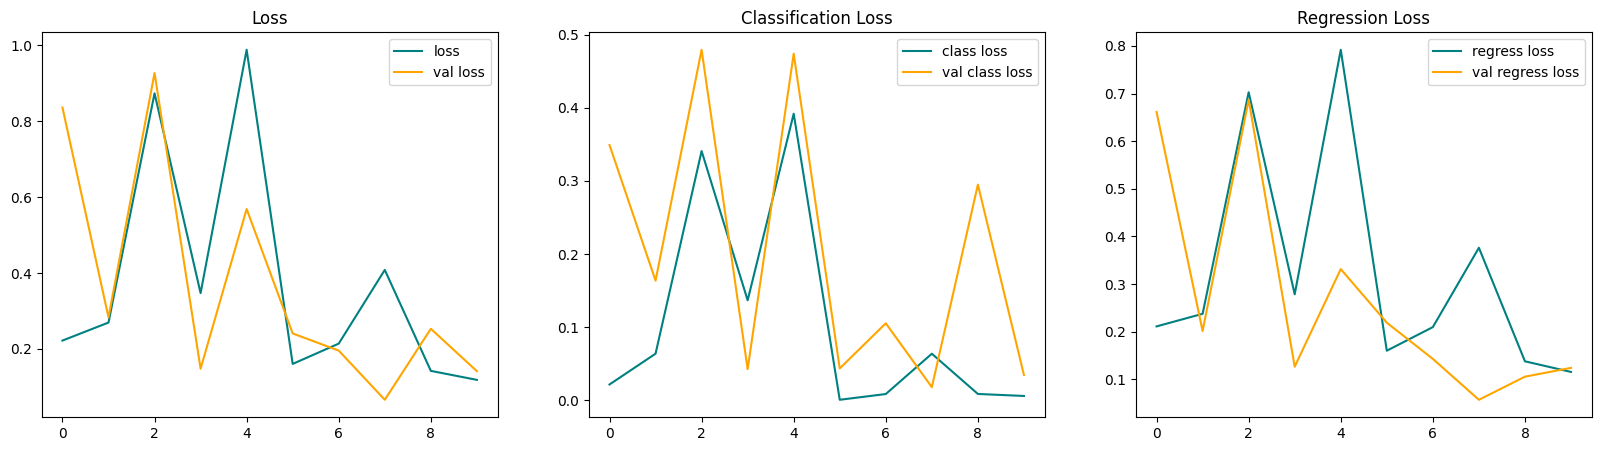

In [95]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


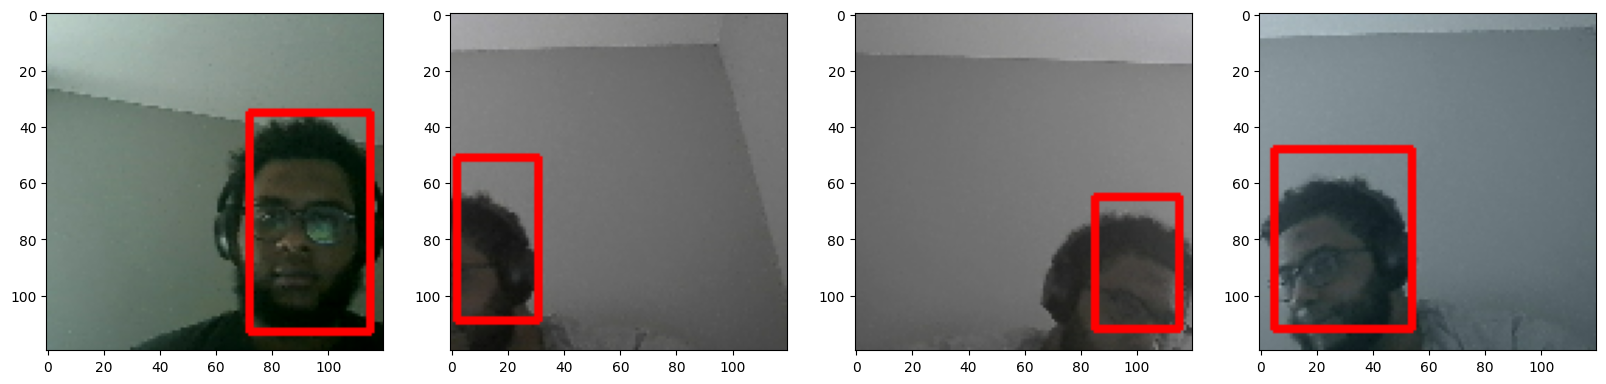

In [98]:
# Make Predictions on Test Set
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    # Make a writable copy of the image
    sample_image_writable = sample_image.copy()

    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image_writable,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (255, 0, 0), 2)

    ax[idx].imshow(sample_image_writable)

plt.show()


In [ ]:
# Real-Time Detection using Webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = frame[50:500, 50:500, :]
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized / 255.0, 0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255, 0, 0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [80, 0])),
                      (255, 0, 0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
